# Wetterdaten von 1950 bis (fast) heute: Vorbereiten

In [53]:
%matplotlib inline

import io
import pathlib
import urllib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In dieser Aufgabe verarbeiten, bereinigen und visualisieren Sie Wetterdaten des Deutschen Wetterdienstes. Der Deutsche Wetterdienst stellt für seine zahlreichen Wetterstationen `zip`-Archive mit ihren Messdaten bereit. Dabei gibt es Archive für verschiedene Häufigkeiten (von zehnminütlich bis zum zehnjährigen Mittel), verschiedene Messgrößen (etwa Sonneneinstrahlung oder Wind), sowie historische oder aktuelle Werte. In dieser Aufgabe interessieren wir uns für die historischen Werte (von 1950 bis 2022) der Temperatur und Luftfeuchtigkeit der Station "Gießen/Wettenberg".


Für eine vollständig bepunktete Abgabe sollten Sie bei der Umsetzung insbesondere auf idiomatischen, performanten, und gut lesbaren Code achten:
* Nutzen Sie `pandas`-Methoden, statt explizit zu iterieren.
* Nutzen Sie Method Chaining, statt Rechnungen zu wiederholen oder unnötige Kopien zu erstellen.
* Formatieren Sie Ihren Code sinnvoll, nutzen Sie "sprechende" Variablen und Methoden wo möglich, und kommentieren Sie wo nötig.

## [0 Punkte] Download von den Seiten des Deutschen Wetterdienstes

Die Funktion `extract_zipfile_from_web` lädt eine `.zip`-Datei herunter und extrahiert sie in ein Verzeichnis (standardmäßig `tmp`). Sie gibt eine Liste der extrahierten Dateien zurück.

In [54]:
def extract_zipfile_from_web(url: str, tmp_dir=pathlib.Path('tmp'), exist_ok=True):
    """Extracts a zipfile from the web to `tmp_dir` and returns list of extracted files.

    url      -- location of the zipfile to download from the web
    tmp_dir  -- output directory for extracted files
    exist_ok -- whether to extract to existing directories

    returns list of paths with extracted files
    """
    tmp_dir.mkdir(exist_ok=exist_ok)

    response = urllib.request.urlopen(url)
    z = zipfile.ZipFile(io.BytesIO(response.read()))

    z.extractall(path=tmp_dir)
    return list(map(pathlib.Path(tmp_dir).joinpath, z.namelist()))

Das gewünschte Archiv (historische, stündliche Messwerte der Temperatur und Luftfeuchte in Gießen/Wettenberg) findet sich unter der folgenden URL:

In [55]:
url = (
    'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/'
    'air_temperature/historical/stundenwerte_TU_01639_19500101_20221231_hist.zip'
)

Laden Sie es zunächst herunter und entpacken Sie es:

In [56]:
extracted_files = extract_zipfile_from_web(url)
extracted_files

[PosixPath('tmp/Metadaten_Stationsname_Betreibername_01639.html'),
 PosixPath('tmp/Metadaten_Stationsname_Betreibername_01639.txt'),
 PosixPath('tmp/Metadaten_Parameter_tu_stunde_01639.html'),
 PosixPath('tmp/Metadaten_Parameter_tu_stunde_01639.txt'),
 PosixPath('tmp/Metadaten_Geraete_Lufttemperatur_01639.html'),
 PosixPath('tmp/Metadaten_Geraete_Lufttemperatur_01639.txt'),
 PosixPath('tmp/Metadaten_Geraete_Rel_Feuchte_01639.html'),
 PosixPath('tmp/Metadaten_Geraete_Rel_Feuchte_01639.txt'),
 PosixPath('tmp/Metadaten_Geographie_01639.txt'),
 PosixPath('tmp/Metadaten_Fehldaten_01639_19500101_20221231.html'),
 PosixPath('tmp/Metadaten_Fehldaten_01639_19500101_20221231.txt'),
 PosixPath('tmp/Metadaten_Fehlwerte_01639_19500101_20221231.txt'),
 PosixPath('tmp/produkt_tu_stunde_19500101_20221231_01639.txt')]

## [1 Punkt] Import des Datensatzes

Das Zip-Archiv enthält einige Dateien mit dem Präfix `Metadaten_`, die Informationen u.A. zu den Messgeräten und zur Geographie enthalten. Die verbleibende Datei mit dem Präfix `produkt_` enthält die tatsächlichen Messwerte. Dabei handelt es sich um eine CSV-artige Datei (lassen Sie nicht von der Endung `.txt` irritieren). Die einzelnen Spalten dieser Datei haben folgende Titel:

```
STATIONS_ID;MESS_DATUM;QN_9;TT_TU;RF_TU;eor
```

`MESS_DATUM` enthält das Messdatum, `TT_TU` die Temperatur in Grad Celsius, und `RF_TU` die relative Luftfeuchtigkeit.

Lesen Sie (ausschließlich) die Spalten `"MESS_DATUM"`, `"TT_TU"` und `"RF_TU"` in einen `DataFrame` ein. Verzichten Sie zunächst auf die Konversion von Datentypen und das Umbenennen von Spalten.

In [57]:
wetterdaten = pd.read_csv("tmp/produkt_tu_stunde_19500101_20221231_01639.txt", delimiter=';', usecols=['MESS_DATUM', 'TT_TU', 'RF_TU'])
wetterdaten

,MESS_DATUM,TT_TU,RF_TU
0,1950010101,-3.6,74.0
1,1950010102,-3.5,74.0
2,1950010103,-3.5,73.0
3,1950010104,-4.2,74.0
4,1950010105,-4.3,74.0
...,...,...,...
639896,2022123119,13.7,71.0
639897,2022123120,14.0,67.0
639898,2022123121,14.6,62.0
639899,2022123122,13.9,65.0


## [4 Punkte] Datensatz aufbereiten

Nach dem Einlesen eines Datensatzes muss dieser häufig aufbereitet werden. Dafür bietet es sich an, ein "Rezept" zu schreiben, dessen einzelne Schritte Sie dann nacheinander implementieren können. Hier verwenden wir dieses "Rezept":

1. Datentypen umwandeln
2. Spalten umbenennen
3. Index wählen

#### Datentypen umwandeln
Die Spalte `MESS_DATUM` enthält das Datum einer jeden Messung. Allerdings hat die Spalte nach Import den Typ `int64` und soll ein Datum im Format `%Y%m%d%H` ("JahrMonatTagStunde") repräsentieren. Das ist nicht in unserem Sinne. Stattdessen würden wir das Datum der Messung lieber mit dem Datentyp `datetime64[ns]` speichern. Damit lassen sich die Daten besser verarbeiten und visualisieren.

Dazu könnten Sie die `.astype`, `.to_datetime`, und `.assign`-Methoden nutzen. Beispielsweise lässt sich eine Series von Jahreszahlen als Integer wie folgt in den Typ `datetime64` umwandeln:

```python
>>> years = pd.Series([2019, 2020])
>>> pd.to_datetime(years.astype(str), format='%Y')
pd.Series(['2019-01-01', '2020-01-01'], dtype=datetime64[ns])
```

Wählen Sie außerdem geeignete Datentypen für Temperatur und Luftfeuchtigkeit.

#### Spalten umbenennen
Benennen Sie die Spalten `MESS_DATUM`, `TT_TU`, und `RF_TU` respektive in `Datum`, `Temperatur`, und `Luftfeuchte` um. Dazu bietet sich die `.rename`-Methode an.

#### Index wählen
Beim Einlesen der Daten hat pandas einen neuen Integer-Index erzeugt. Stattdessen wollen wir das `Datum` als Index wählen. Nutzen Sie dazu die `.set_index`-Methode.

In [58]:
wetterdaten_corrected = wetterdaten.copy() 
wetterdaten_corrected['MESS_DATUM'] = pd.to_datetime(wetterdaten['MESS_DATUM'].astype(str), format='%Y%m%d%H') # correct date format
wetterdaten_corrected['TT_TU'] = wetterdaten_corrected['TT_TU'].astype('float64') # assign correct data type
wetterdaten_corrected['RF_TU'] = wetterdaten_corrected['RF_TU'].astype('int64') # correct data type
wetterdaten_corrected = wetterdaten_corrected.rename(columns={'MESS_DATUM': 'Datum', 'TT_TU': 'Temperatur', 'RF_TU': 'Luftfeuchte'}) # rename columns
wetterdaten_corrected = wetterdaten_corrected.set_index('Datum') # set index


## [5 Punkte] Datensatz bereinigen

Bei Messungen über lange Zeiträume hinweg kann es durchaus sein, dass einzelne Messungen fehlgeschlagen sind, etwa weil ein Messgerät eine Fehlfunktion hat oder gewartet wird. Zum Teil stehen dann im Datensatz unsinnige Messwerte. Solche Daten müssen detektiert und aus dem Datensatz entfernt werden — ein Problem, das auch allgemein bei großen Datenmengen auftreten kann.

Ein "Rezept" zum Finden unsinniger Messwerten kann folgende Schritte beinhalten:

* Überlegen Sie sich zunächst, welchen Wertebereich Sie (grob) erwarten.
* Prüfen Sie, ob Ihr Datensatz bereits fehlende Werte enthält
* Wiederholen Sie dann die folgenden Schritte, bis Sie keine unsinnigen Werte mehr finden:
    1. Prüfen Sie (besonders) Maximum, Minimum, und Median mit der `.describe`-Methode.
    2. Erstellen Sie ein Histogramm für jede Messgröße.
    3. Suchen Sie in den `.value_counts` nach Werten, die besonders häufig oder besonders selten vorkommen.
    4. Ersetzen Sie alle unsinnigen Messwerte mit einem fehlenden Wert (je nach Datentyp `np.nan`, `pd.NA`, `np.datetime64('NaT')` oder `None`)
    
Wenn Werte fehlen oder entfernt werden mussten, können zum Umgang damit mehrere Strategien sinnvoll sein:
* im Datensatz belassen
* aus dem Datensatz entfernen
* interpolieren, z.B. linear, mit Splines, oder dem nächsten bekannten Wert
* mit einem sinnvollen Wert ersetzen, z.B. Mittelwert oder Median

Überprüfen Sie auf geeignete Weise, ob und welche Messwerte für Temperatur und/oder Luftfeuchtigkeit in einem nicht sinnvollen Bereich liegen, und entfernen Sie diese. Achten Sie darauf, keine unnötigen Kopien der Daten zu erzeugen, sondern den existierenden `DataFrame` geeignet anzupassen. Dokumentieren Sie Ihr Vorgehen angemessen.

          Temperatur    Luftfeuchte
count  639901.000000  639901.000000
mean        9.145230      76.653179
std        17.577059      34.645799
min      -999.000000    -999.000000
25%         3.500000      67.000000
50%         9.200000      82.000000
75%        15.000000      91.000000
max        38.000000     100.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639901 entries, 1950-01-01 01:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperatur   639901 non-null  float64
 1   Luftfeuchte  639901 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 14.6 MB
None
Temperatur
 10.0    3842
 13.0    3823
 12.0    3728
 15.0    3710
 6.0     3667
         ... 
-20.1       1
-18.9       1
-19.2       1
-18.1       1
 37.5       1
Name: count, Length: 582, dtype: int64
Luftfeuchte
95    21466
90    21377
94    21255
93    20857
92    20623
      ...  
11        5
8   

/tmp/ipykernel_23707/2544581709.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[idx][(df[idx] < l_border) | (df[idx] > h_border)] = pd.NA


          Temperatur    Luftfeuchte
count  639746.000000  639404.000000
mean        9.389487      77.489270
std         7.919670      17.355705
min       -20.900000       7.000000
25%         3.500000      67.000000
50%         9.200000      82.000000
75%        15.000000      91.000000
max        38.000000     100.000000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 639901 entries, 1950-01-01 01:00:00 to 2022-12-31 23:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Temperatur   639746 non-null  float64
 1   Luftfeuchte  639404 non-null  float64
dtypes: float64(2)
memory usage: 14.6 MB
None


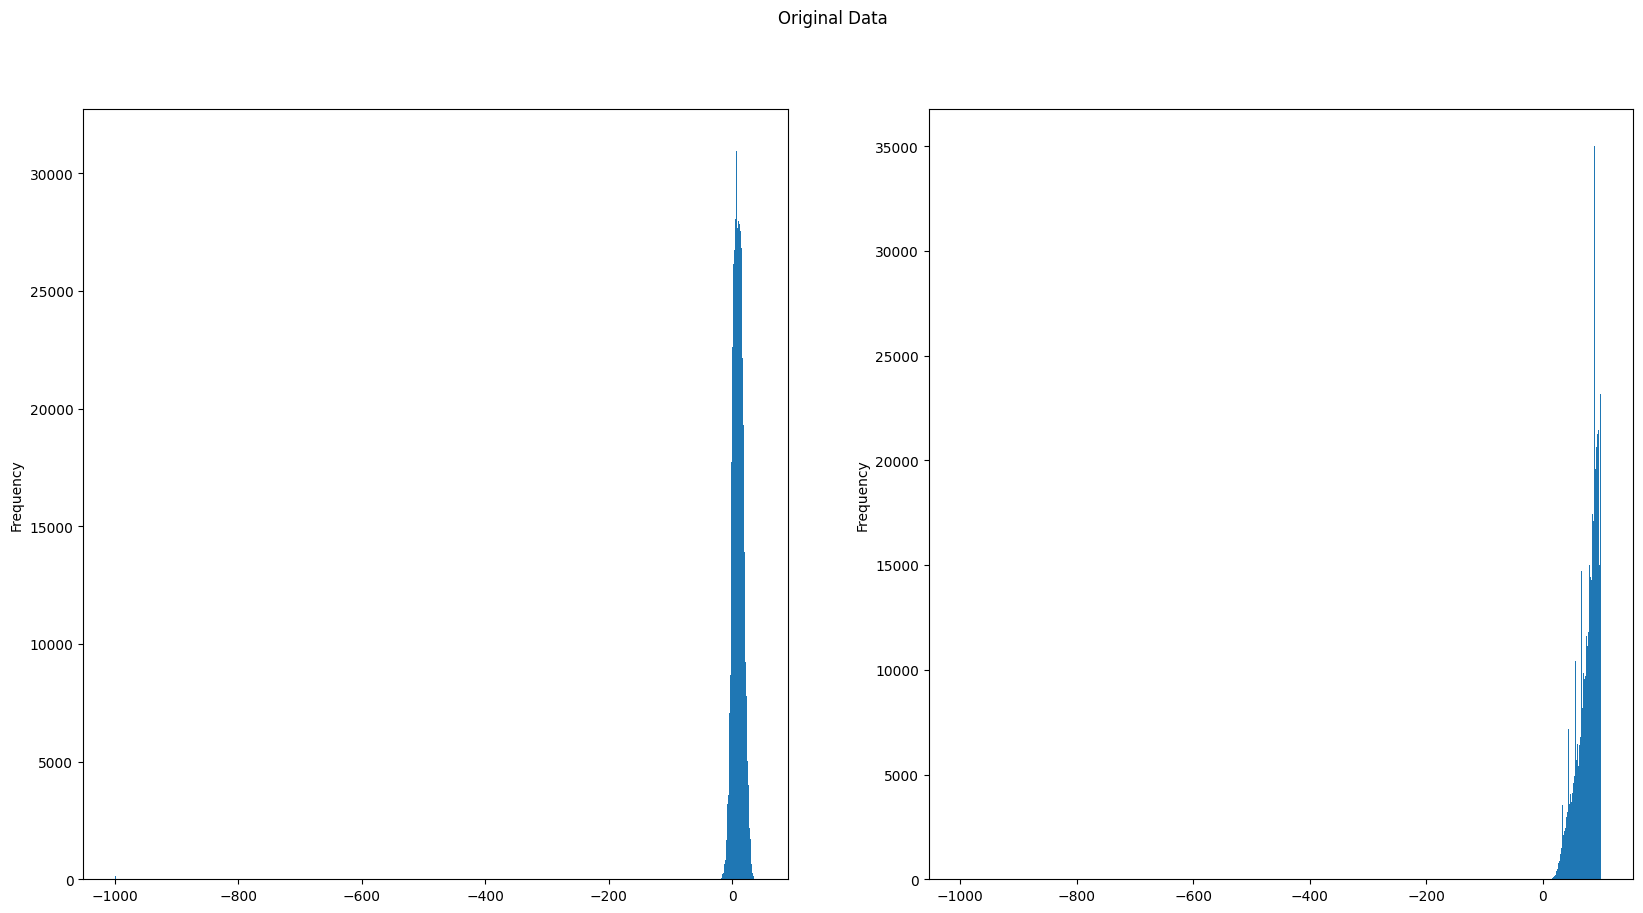

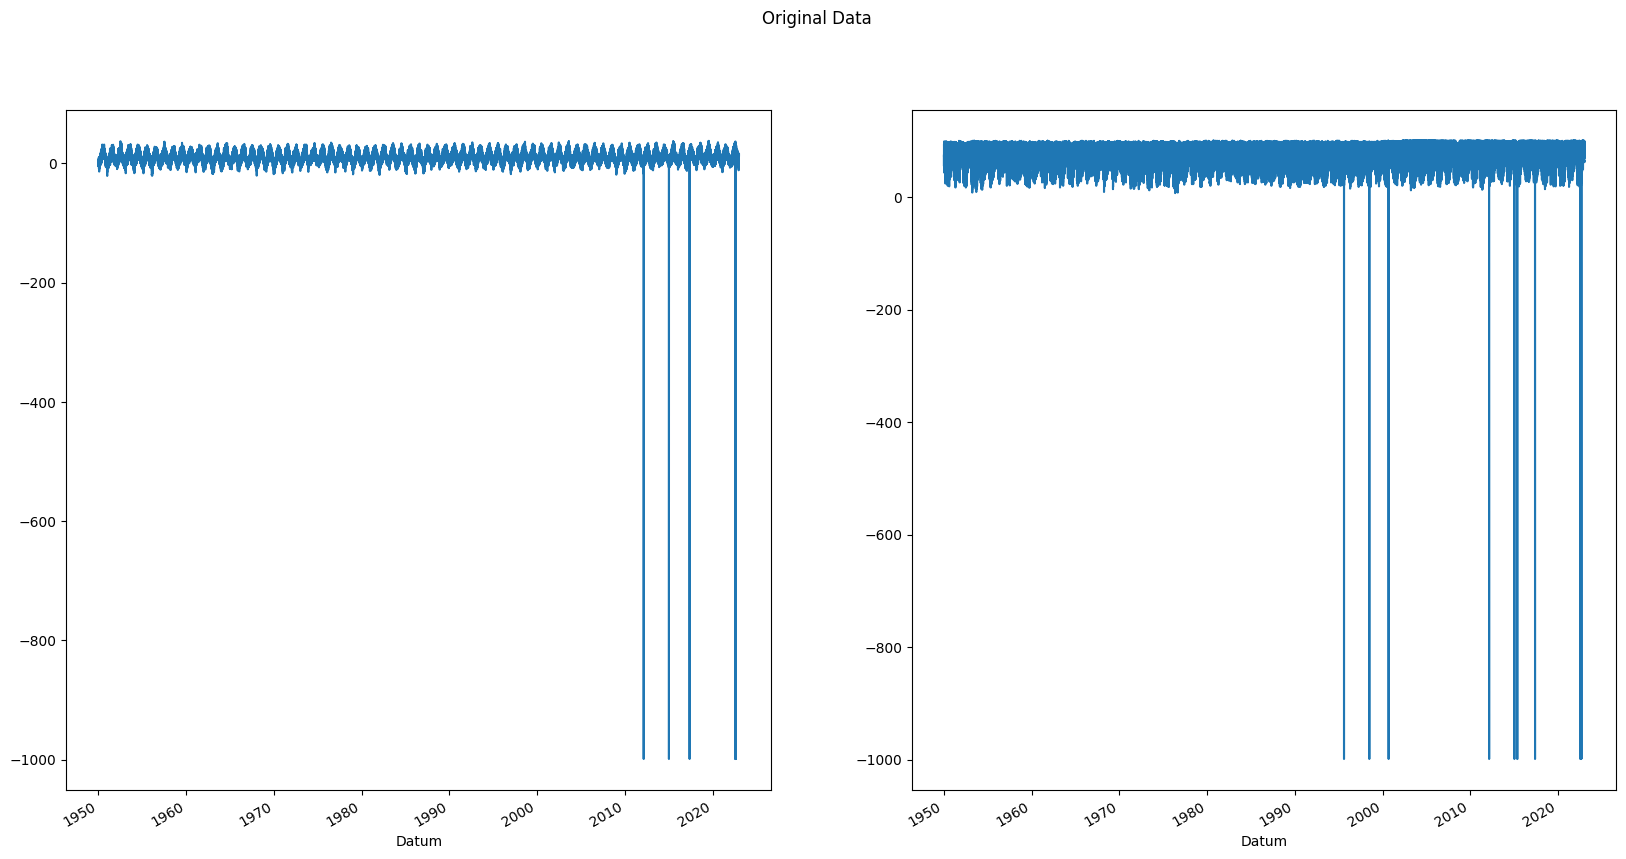

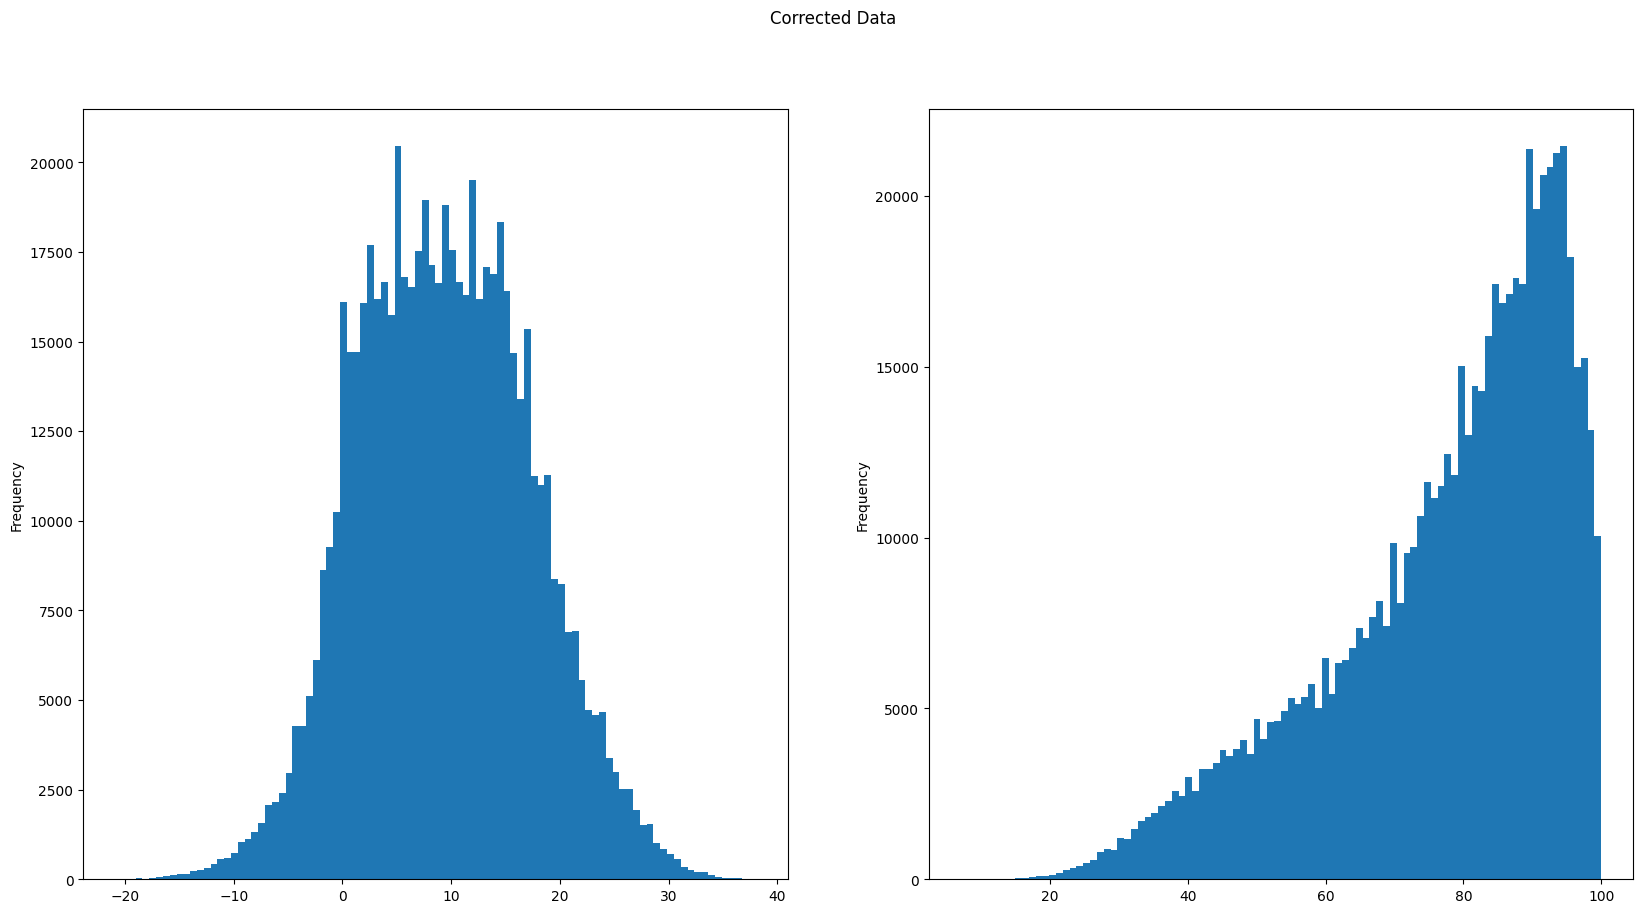

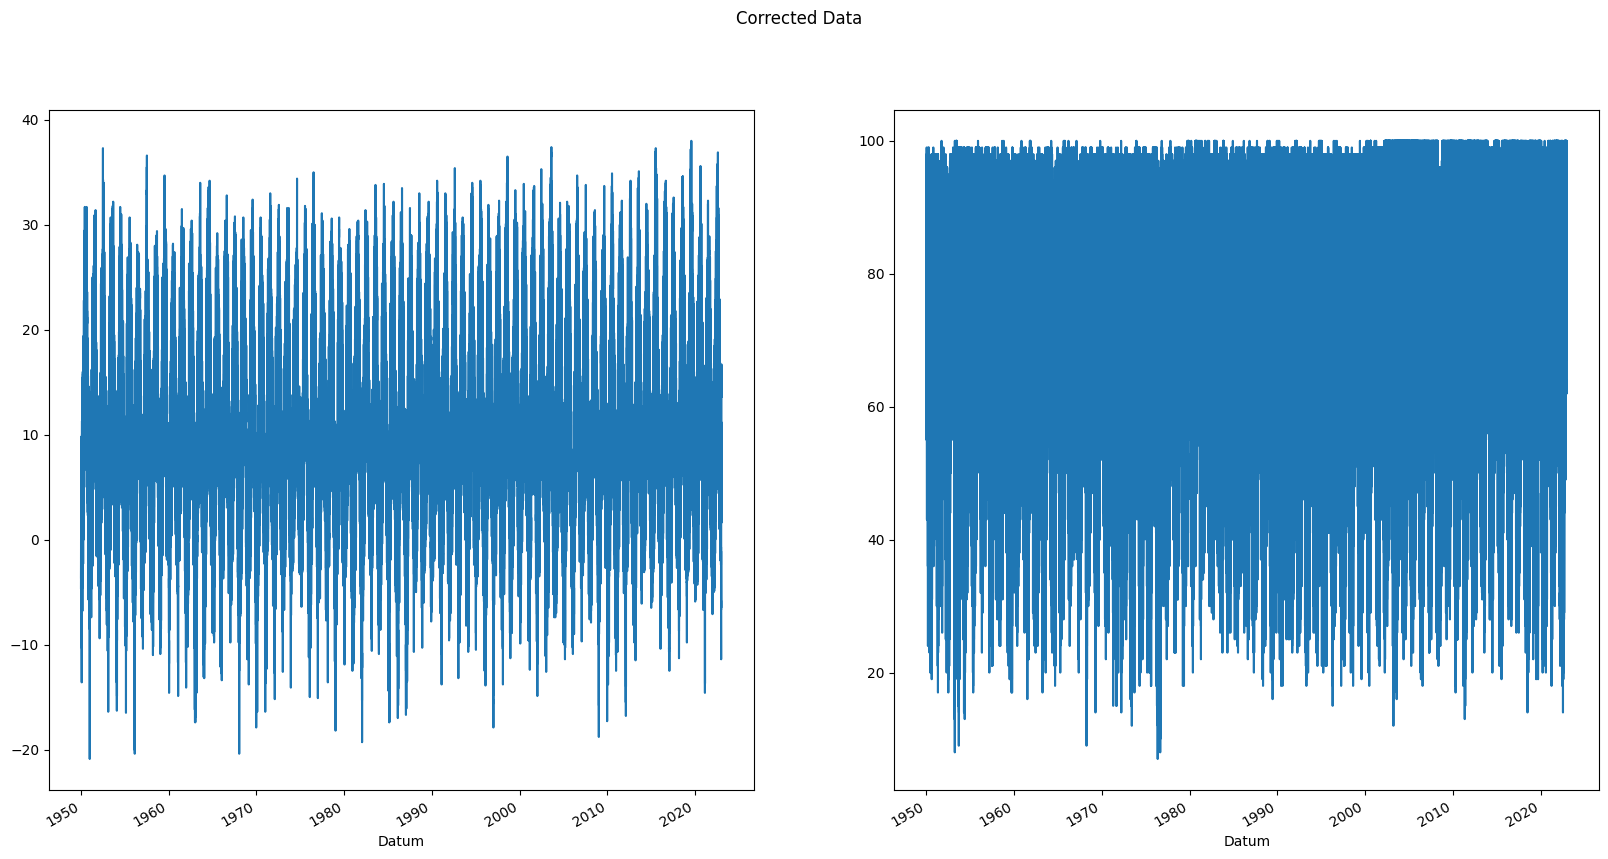

In [59]:
def print_hist(df: pd.DataFrame, bin: int = 100, name: str = None):   
    '''
    Prints a histogram for the columns 'Temperatur' and 'Luftfeuchte' of the given DataFrame.
    '''
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle(name)
    df['Temperatur'].plot(kind='hist',
                          bins=bin, 
                          ax=axes[0])
    df['Luftfeuchte'].plot(kind='hist',
                           bins=bin, 
                           ax=axes[1])
    
def print_lineplot(df: pd.DataFrame, name: str = None): 
    '''
    Prints a lineplot for the columns 'Temperatur' and 'Luftfeuchte' of the given DataFrame.
    '''  
    fig, axes = plt.subplots(1, 2, figsize=(20,10))
    fig.suptitle(name)
    df['Temperatur'].plot(kind='line', 
                          ax=axes[0])
    df['Luftfeuchte'].plot(kind='line',
                           ax=axes[1])
    
def describe_df(df: pd.DataFrame):
    '''
    Prints the description and info of the given DataFrame.
    '''
    print(df.describe())
    print(df.info())
    
def df_count(df: pd.DataFrame):
    '''
    Prints the value counts of the given DataFrame.
    '''
    print(df['Temperatur'].value_counts())
    print(df['Luftfeuchte'].value_counts())
    
def delete_values(df: pd.DataFrame, idx: str, l_border: float = None, h_border: float = None):
    '''
    Deletes values in the given DataFrame that are not in the given range.
    '''
    df[idx][(df[idx] < l_border) | (df[idx] > h_border)] = pd.NA
    
def modify_data(df: pd.DataFrame):
    '''
    Modifies the given DataFrame by filling the NaN values with the mean of the column.
    '''
    df['Temperatur'].fillna(df['Temperatur'].mean())
    df['Luftfeuchte'].fillna(df['Luftfeuchte'].mean())

# display the information and plots of the original DataFrame    
print_hist(wetterdaten_corrected, 1000, 'Original Data')
print_lineplot(wetterdaten_corrected, 'Original Data')
describe_df(wetterdaten_corrected)
df_count(wetterdaten_corrected)

'''Erste Überlegung:
    Temperaturen im Bereich -50 bis 50°C
    Luffeuchtigkeit im Bereich von 0 bis 100%'''

# modify the DataFrame by deleting values that are not in the plausible range
delete_values(wetterdaten_corrected, 'Luftfeuchte', 0, 100)
delete_values(wetterdaten_corrected, 'Temperatur', -50, 50)

'''Es ist zu sehen, dass es Werte gibt, die deutlich rausstechen. Diese wurden durch die Korrektur entfernt.
   Die entferneten Werte ersetze ich durch den Mittelwert, da es nur sehr wenige sind und die Interpolation sehr vile zeit benötigt.'''

# filling the NaN values with the mean of the column
modify_data(wetterdaten_corrected)

# display the information and plots of the modified DataFrame
print_hist(wetterdaten_corrected, 94, 'Corrected Data')
print_lineplot(wetterdaten_corrected, 'Corrected Data')
describe_df(wetterdaten_corrected)

